In [1]:
import json
from nuscenes.nuscenes import NuScenes
import matplotlib.pyplot as plt
from torchvision.io import read_image
from torchvision.utils import draw_bounding_boxes
import os
from get_2D_boxes_from_sample_data import get_2D_boxes_from_sample_data
import torch
import ipywidgets as widgets
import torchvision
import io
import random

In [2]:
data_path = '../../data'  # Caminho até o diretório onde os dados da nuscenes estão
nusc = NuScenes(version='v1.0-trainval', dataroot=data_path, verbose=True)  # Carrega o dataset

Loading NuScenes tables for version v1.0-trainval...
23 category,
8 attribute,
4 visibility,
64386 instance,
12 sensor,
10200 calibrated_sensor,
2631083 ego_pose,
68 log,
850 scene,
34149 sample,
2631083 sample_data,
1166187 sample_annotation,
4 map,
Done loading in 36.782 seconds.
Reverse indexing ...
Done reverse indexing in 9.9 seconds.


In [3]:
faster_rcnn_detections = json.load(open('/storage/conecta2030/nuScenes-exploration/outputs/faster_rcnn/detections_mini.json'))
ssd_detections = json.load(open('/storage/conecta2030/nuScenes-exploration/outputs/ssd/detections_full.json'))

In [4]:
plt.rcParams["savefig.bbox"] = 'tight'

def show(img):
    plt.figure(figsize=(20, 20))
    plt.imshow(img.permute(1, 2, 0))
    plt.axis('off')
    plt.show()

In [5]:
def load_nuscenes_image(sample_num):
    '''
    Carrega a imagem da câmera frontal do sample `sample_num`
    '''
    if type(sample_num) == int:
        sample_data = nusc.get('sample_data', nusc.sample[sample_num]['data']['CAM_FRONT'])
        image_path = os.path.join(data_path, sample_data['filename'])
        image = read_image(image_path)
    else:
        sample_data = nusc.get('sample_data', sample_num)
        image_path = os.path.join(data_path, sample_data['filename'])
        image = read_image(image_path)
    return sample_data, image

In [18]:
_, image_1 = load_nuscenes_image('ba01f58b926a472b9d146cb5a54e9a2e')
boxes_truth, classes_truth = get_2D_boxes_from_sample_data(nusc, 'ba01f58b926a472b9d146cb5a54e9a2e', visibilities=['4'])

boxes_faster_rcnn = list(faster_rcnn_detections['ba01f58b926a472b9d146cb5a54e9a2e']['boxes'])
labels_faster_rcnn = list(faster_rcnn_detections['ba01f58b926a472b9d146cb5a54e9a2e']['labels'])

boxes_ssd = list(ssd_detections['ba01f58b926a472b9d146cb5a54e9a2e']['boxes'])
labels_ssd = list(ssd_detections['ba01f58b926a472b9d146cb5a54e9a2e']['labels'])

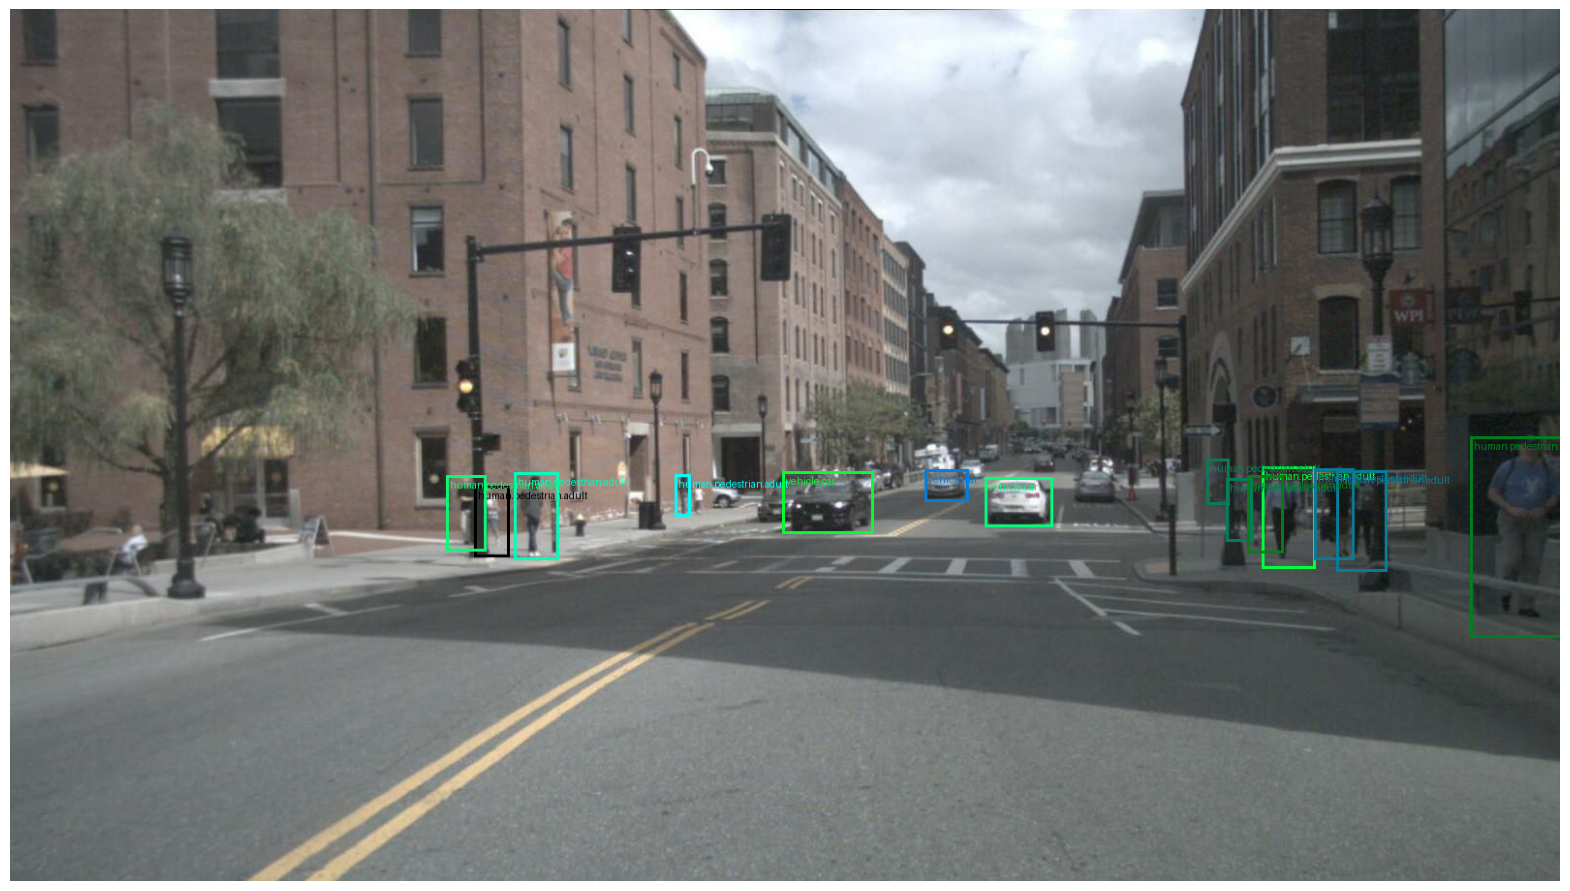

In [19]:
show(draw_bounding_boxes(image_1, torch.tensor(boxes_truth), labels=classes_truth, width=3))

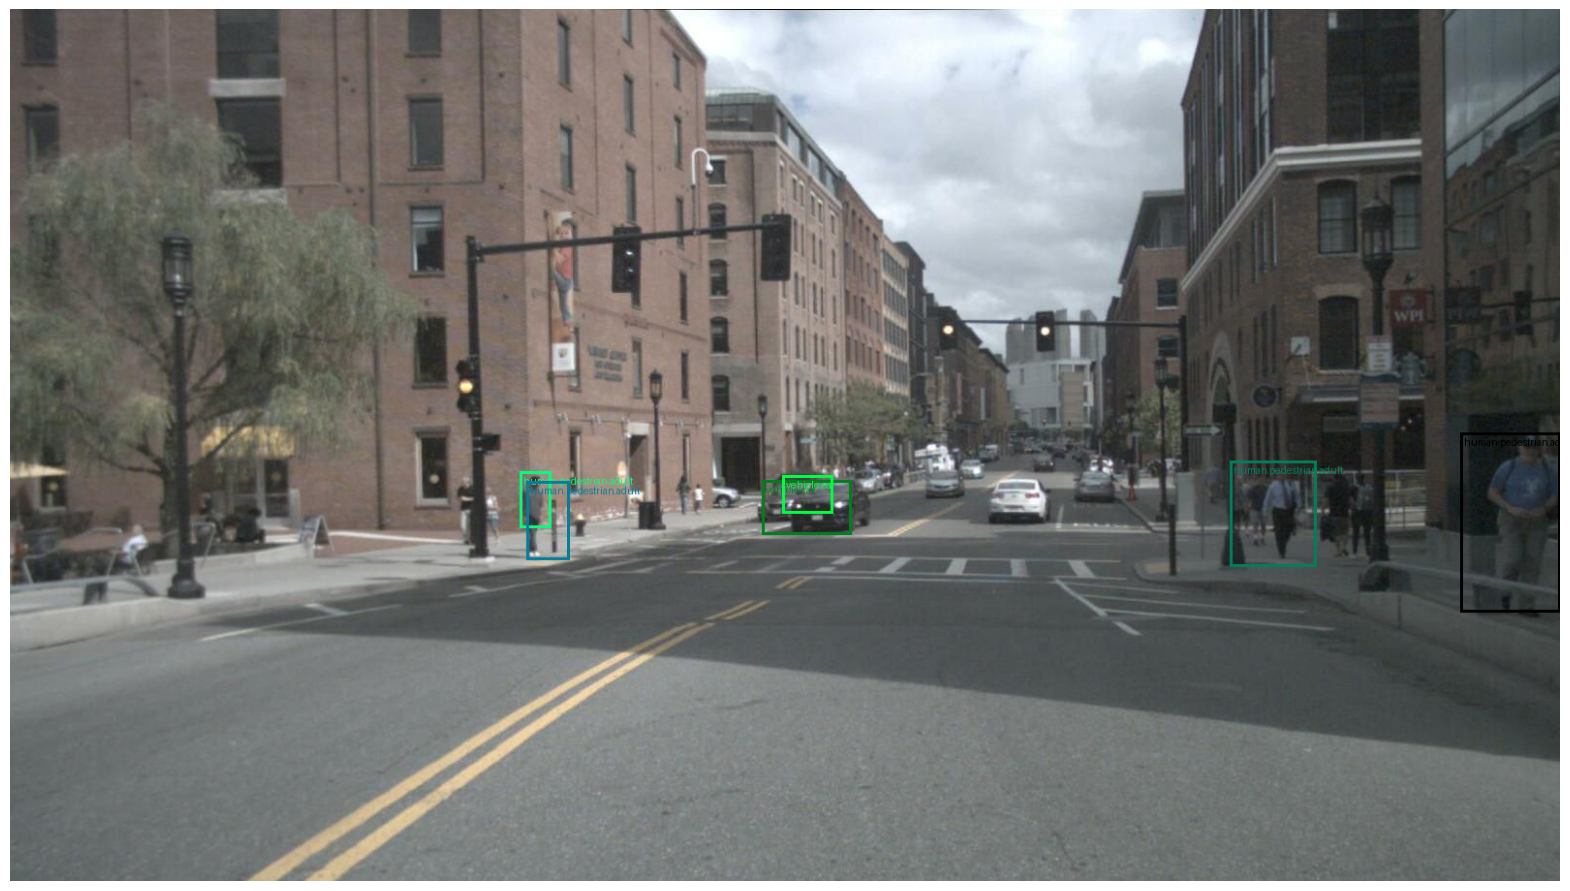

In [8]:
show(draw_bounding_boxes(image_1, torch.tensor(boxes_faster_rcnn), labels=labels_faster_rcnn, width=3))

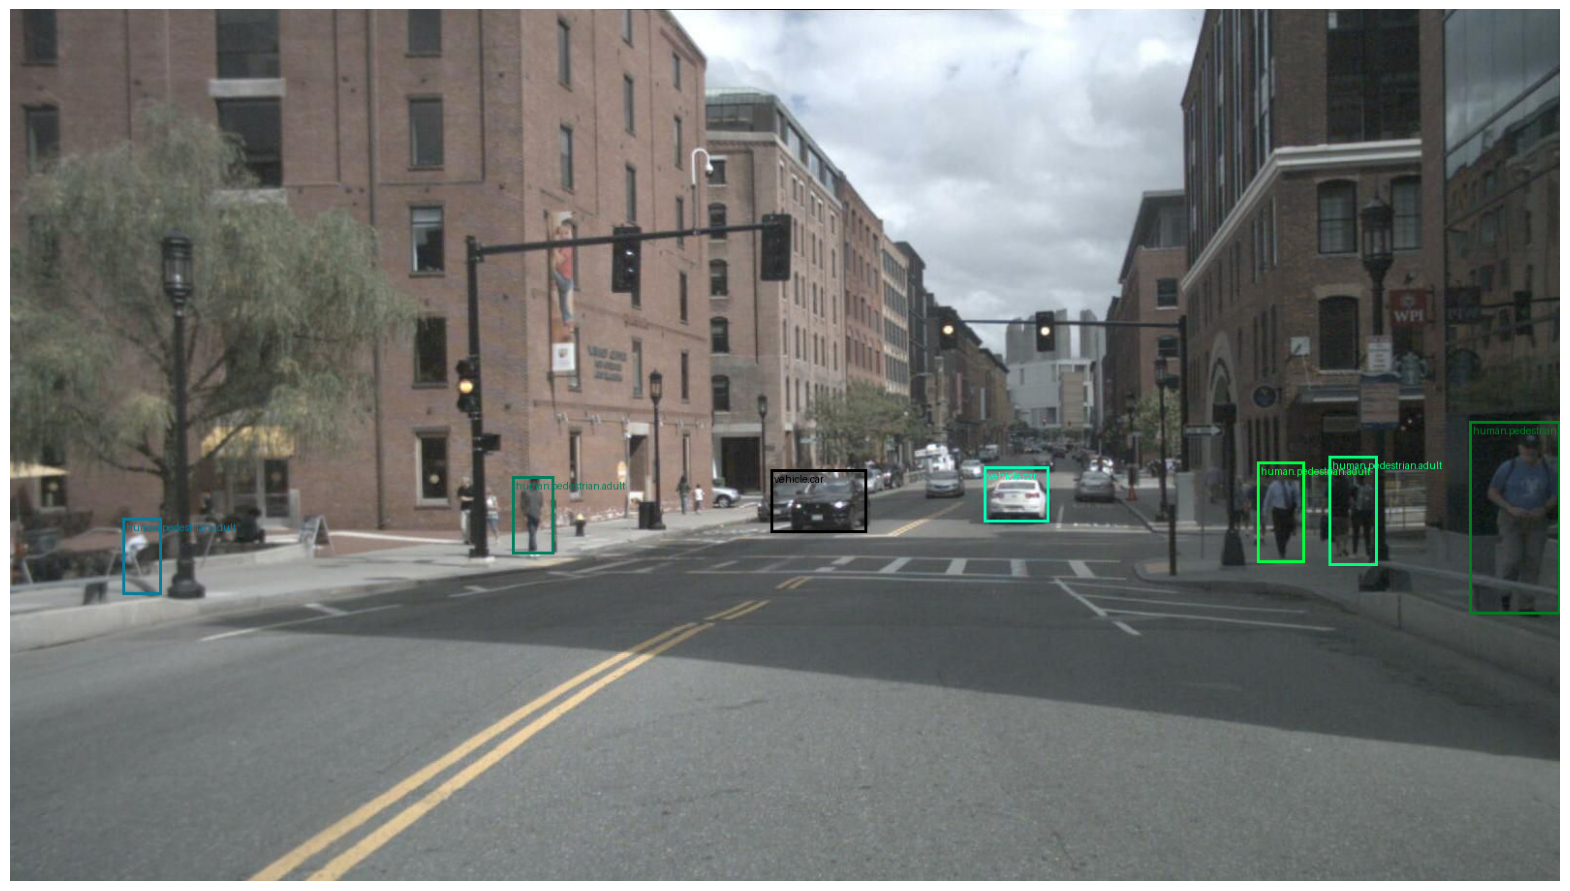

In [9]:
show(draw_bounding_boxes(image_1, torch.tensor(boxes_ssd), labels=labels_ssd, width=3))

In [10]:
items = [widgets.Label(str(i)) for i in range(4)]
left_box = widgets.VBox([items[0], items[1]])
right_box = widgets.VBox([items[2], items[3]])
widgets.HBox([left_box, right_box])

In [11]:

image = torchvision.transforms.ToPILImage()(image_1)
img_bytes = io.BytesIO()
image.save(img_bytes, format='jpeg')
img_bytes = img_bytes.getvalue()

widgets.Image(
    value=img_bytes,
    format='jpeg',
    width=700,
    height=700,
)

Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x08\x06\x0…

In [12]:

def convert_tensor_to_bytes(image_tensor):
    image = torchvision.transforms.ToPILImage()(image_tensor)
    img_bytes = io.BytesIO()
    image.save(img_bytes, format='jpeg')
    img_bytes = img_bytes.getvalue()
    return img_bytes

widgets.Image(
    value=convert_tensor_to_bytes(draw_bounding_boxes(image_1, torch.tensor(boxes_truth), labels=classes_truth, width=3)),
    format='jpeg',
    width=700,
    height=700,
)

Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x08\x06\x0…

In [13]:
faster_rcnn_gt_img_widget = widgets.Image(
    value=convert_tensor_to_bytes(draw_bounding_boxes(image_1, torch.tensor(boxes_truth), labels=classes_truth, width=3)),
    format='jpeg',
    width=700,
    height=700,
)

faster_rcnn_predicted_img_widget = widgets.Image(
    value=convert_tensor_to_bytes(draw_bounding_boxes(image_1, torch.tensor(boxes_faster_rcnn), labels=labels_faster_rcnn, width=3)),
    format='jpeg',
    width=700,
    height=700,
)

ground_truth_label_widget = widgets.Label(
    value='GT'
)

predicted_label_widget = widgets.Label(
    value='Faster R-CNN predictions'
)

widgets.Box(
    [
        widgets.HBox(
            [
                widgets.VBox(
                    [
                        ground_truth_label_widget,
                        faster_rcnn_gt_img_widget
                    ]
                ),
                widgets.VBox(
                    [
                        predicted_label_widget,
                        faster_rcnn_predicted_img_widget
                    ]
                ),
            ]
        )
    ]
)

Box(children=(HBox(children=(VBox(children=(Label(value='GT'), Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\…

In [14]:
img_widget_test = widgets.Image(
    format='jpeg'
)
img_widget_test.value = convert_tensor_to_bytes(draw_bounding_boxes(image_1, torch.tensor(boxes_truth), labels=classes_truth, width=3))

In [15]:
from nuscenes.utils.splits import create_splits_scenes

val_scenes_names = create_splits_scenes()['val']
all_val_sampledatas = []
val_scenes_tokens = [nusc.field2token('scene', 'name', scene_name)[0] for scene_name in val_scenes_names]

sensors = ['CAM_FRONT', 'CAM_FRONT_LEFT', 'CAM_FRONT_RIGHT', 'CAM_BACK', 'CAM_BACK_LEFT', 'CAM_BACK_RIGHT']
for scene_token in val_scenes_tokens:
    scene = nusc.get('scene', scene_token)
    sample_token = scene['first_sample_token']
    while sample_token != '':
        sample = nusc.get('sample', sample_token)
        all_val_sampledatas.extend([nusc.get('sample_data', sample['data'][sensor]) for sensor in sensors])
        sample_token = sample['next']

print(len(all_val_sampledatas))

36114


In [16]:
import PIL.Image as Image

predictions_dict = {
    'Faster R-CNN': json.load(open('/storage/conecta2030/nuScenes-exploration/outputs/faster_rcnn/detections_full.json')),
    'SSD': json.load(open('/storage/conecta2030/nuScenes-exploration/outputs/ssd/detections_full.json'))
}
save_path = 'predictions'


def generate_algo_widgets(algo_name):
    gt_img_widget = widgets.Image(
        format='jpeg'
    )

    algo_predicted_img_widget = widgets.Image(
        format='jpeg'
    )

    ground_truth_label_widget = widgets.Label(
        value='GT'
    )

    predicted_label_widget = widgets.Label(
        value=f'{algo_name} predictions'
    )

    algo_box_widget = widgets.Box(
        [
            widgets.HBox(
                [
                    widgets.VBox(
                        [
                            ground_truth_label_widget,
                            gt_img_widget
                        ]
                    ),
                    widgets.VBox(
                        [
                            predicted_label_widget,
                            algo_predicted_img_widget
                        ]
                    ),
                ]
            )
        ]
    )

    return {
        'algo_box': algo_box_widget,
        'gt_img': gt_img_widget,
        'algo_predicted_img': algo_predicted_img_widget
    }

def get_random_sample_data():
    return random.choice(all_val_sampledatas)

def update_algo_widgets(new_sample_data, algos_infos: dict, token_label_widget):
    token = new_sample_data['token']
    _, image = load_nuscenes_image(token)
    boxes_truth, classes_truth = get_2D_boxes_from_sample_data(nusc, token)
    if len(classes_truth) > 0:
        image_with_gt = convert_tensor_to_bytes(draw_bounding_boxes(image, torch.tensor(boxes_truth), labels=classes_truth, width=3))
    else:
        image_with_gt = convert_tensor_to_bytes(image)
    token_label_widget.value = token

    for _, algo_info in algos_infos.items():
        boxes_predicted = list(algo_info['predictions'][token]['boxes'])
        labels_predicted = list(algo_info['predictions'][token]['labels'])

        if len(labels_predicted) > 0:
            image_with_predictions = convert_tensor_to_bytes(draw_bounding_boxes(image, torch.tensor(boxes_predicted), labels=labels_predicted, width=3))
        else:
            image_with_predictions = convert_tensor_to_bytes(image)

        algo_info['widgets']['gt_img'].value = image_with_gt
        algo_info['widgets']['algo_predicted_img'].value = image_with_predictions

def save_images(algos_infos: dict, token):
    os.makedirs(f'{save_path}/{token}', exist_ok=True)

    image_with_gt = None
    for algo_name, algo_info in algos_infos.items():
        if image_with_gt is None:
            image_with_gt = algo_info['widgets']['gt_img'].value
        
        algo_image = algo_info['widgets']['algo_predicted_img'].value
        Image.open(io.BytesIO(algo_image)).save(f"{save_path}/{token}/{algo_name}.jpg")
    
    Image.open(io.BytesIO(image_with_gt)).save(f"{save_path}/{token}/gt.jpg")

def generate_predictions_widgets():
    algos_infos = {}
    for algo_name, algo_predictions in predictions_dict.items():
        algos_infos[algo_name] = {
            'predictions': algo_predictions,
            'widgets': generate_algo_widgets(algo_name)
        }
    
    token_label_widget = widgets.Label()

    def update(_arg):
        update_algo_widgets(get_random_sample_data(), algos_infos, token_label_widget)
    
    btn_update_widget = widgets.Button(
        description='Update',
    )
    btn_update_widget.on_click(update)

    def save(_arg):
        save_images(algos_infos, token_label_widget.value)

    btn_save = widgets.Button(
        description="Save"
    )
    btn_save.on_click(save)

    final_box = widgets.VBox(
        [
            token_label_widget,
            *[algo_info['widgets']['algo_box'] for algo_info in algos_infos.values()],
            widgets.HBox(
                [
                    btn_update_widget, btn_save
                ]
            )
        ]
    )

    update('')

    return final_box

generate_predictions_widgets()